In [1]:
"""
Create a machine learning model that can predict the genere of a movie 
based on its plot summary or other textual information.
You can use techniques like TF-IDF or word embeddingds with clasifiers such as 
Naive Bayes, Logistic Regression, Random Forest Classifier, K Neighbors Classifier or Support Vector Machine.
"""

'\nCreate a machine learning model that can predict the genere of a movie \nbased on its plot summary or other textual information.\nYou can use techniques like TF-IDF or word embeddingds with clasifiers such as \nNaive Bayes, Logistic Regression, Random Forest Classifier, K Neighbors Classifier or Support Vector Machine.\n'

**Importing Libraries**

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score

import spacy

from scipy import sparse

**Reading the Data**

In [4]:
train=pd.read_csv('/kaggle/input/movie-genre-class/Genre Classification Dataset/train_data.txt',sep=':::',header=None,names=['id','title','genre','description'])
test=pd.read_csv('/kaggle/input/movie-genre-class/Genre Classification Dataset/test_data_solution.txt',sep=':::',header=None,names=['id','title','genre','description'])

In [5]:
train

,id,title,genre,description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...,...
54209,54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...
54210,54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g..."
54212,54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...


In [6]:
train.describe()

,id
count,54214.000000
mean,27107.500000
std,15650.378084
min,1.000000
25%,13554.250000
50%,27107.500000
75%,40660.750000
max,54214.000000


In [7]:
train.isnull().sum()

id             0
title          0
genre          0
description    0
dtype: int64

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           54214 non-null  int64 
 1   title        54214 non-null  object
 2   genre        54214 non-null  object
 3   description  54214 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [9]:
test

,id,title,genre,description
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...
...,...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)",horror,"Covering multiple genres, Tales of Light & Da..."
54196,54197,Der letzte Mohikaner (1965),western,As Alice and Cora Munro attempt to find their...
54197,54198,Oliver Twink (2007),adult,A movie 169 years in the making. Oliver Twist...
54198,54199,Slipstream (1973),drama,"Popular, but mysterious rock D.J Mike Mallard..."


In [10]:
test.describe()

,id
count,54200.000000
mean,27100.500000
std,15646.336632
min,1.000000
25%,13550.750000
50%,27100.500000
75%,40650.250000
max,54200.000000


In [11]:
test.isnull().sum()

id             0
title          0
genre          0
description    0
dtype: int64

In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           54200 non-null  int64 
 1   title        54200 non-null  object
 2   genre        54200 non-null  object
 3   description  54200 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [13]:
# dropping off unnecessary columns

train=train.drop(['id'],axis=1)
test=test.drop(['id'],axis=1)

In [14]:
## Feature Creation

train['title'][0].split('(')[-1][:4]

'2009'

In [15]:
train['title'][0].split('(')[:-1][0]

' Oscar et la dame rose '

In [16]:
def extract_year(data):
    if data.split('(')[-1][:4].isdigit():
        return int(data.split('(')[-1][:4])
    return None

train['year']=train['title'].apply(extract_year)
test['year']=test['title'].apply(extract_year)

In [17]:
def transform_title(data):
    if data.split('(')[-1][:4].isdigit():
        return data.split('(')[:-1][0]
    return None

train['title']=train['title'].apply(transform_title)
test['title']=test['title'].apply(transform_title)

In [18]:
train

,title,genre,description,year
0,Oscar et la dame rose,drama,Listening in to a conversation between his do...,2009.0
1,Cupid,thriller,A brother and sister with a past incestuous r...,1997.0
2,"Young, Wild and Wonderful",adult,As the bus empties the students for their fie...,1980.0
3,The Secret Sin,drama,To help their unemployed father make ends mee...,1915.0
4,The Unrecovered,drama,The film's title refers not only to the un-re...,2007.0
...,...,...,...,...
54209,"""Bonino""",comedy,This short-lived NBC live sitcom centered on ...,1953.0
54210,None,horror,The NEXT Generation of EXPLOITATION. The sist...,NaN
54211,Ronald Goedemondt: Ze bestaan echt,documentary,"Ze bestaan echt, is a stand-up comedy about g...",2008.0
54212,Make Your Own Bed,comedy,Walter and Vivian live in the country and hav...,1944.0


**Missing Valuses**

In [19]:
missing_val=train.isna().sum()['year']
total_val=train.shape[0]
print(f'"Year" Column on train dataset got {(missing_val/total_val)*100} percent missing values.')

"Year" Column on train dataset got 4.965507064595861 percent missing values.


In [20]:
missing_val=test.isna().sum()['year']
total_val=test.shape[0]
print(f'"Year" Column on test dataset got {(missing_val/total_val)*100} percent missing values.')

"Year" Column on test dataset got 5.119926199261993 percent missing values.


**EDA**

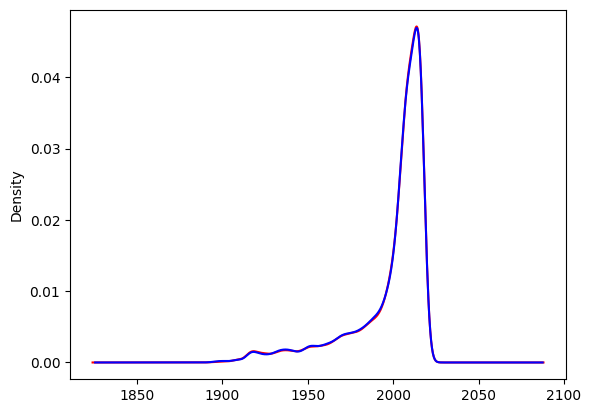

In [21]:
train['year'].plot(kind='kde',color='red')
test['year'].plot(kind='kde',color='blue')
plt.show()

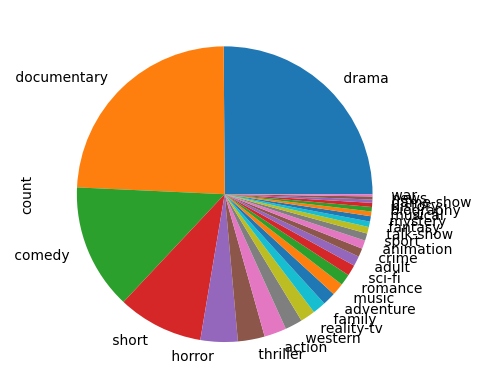

In [22]:
train['genre'].value_counts().plot(kind='pie')
plt.show()

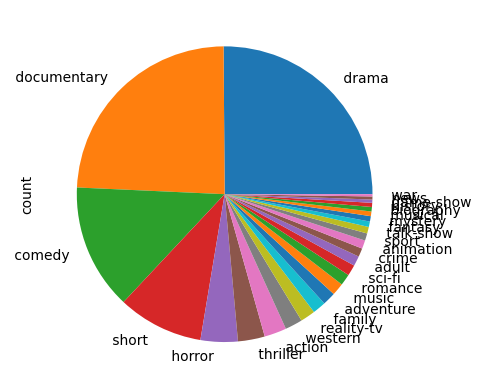

In [23]:
test['genre'].value_counts().plot(kind='pie')
plt.show()

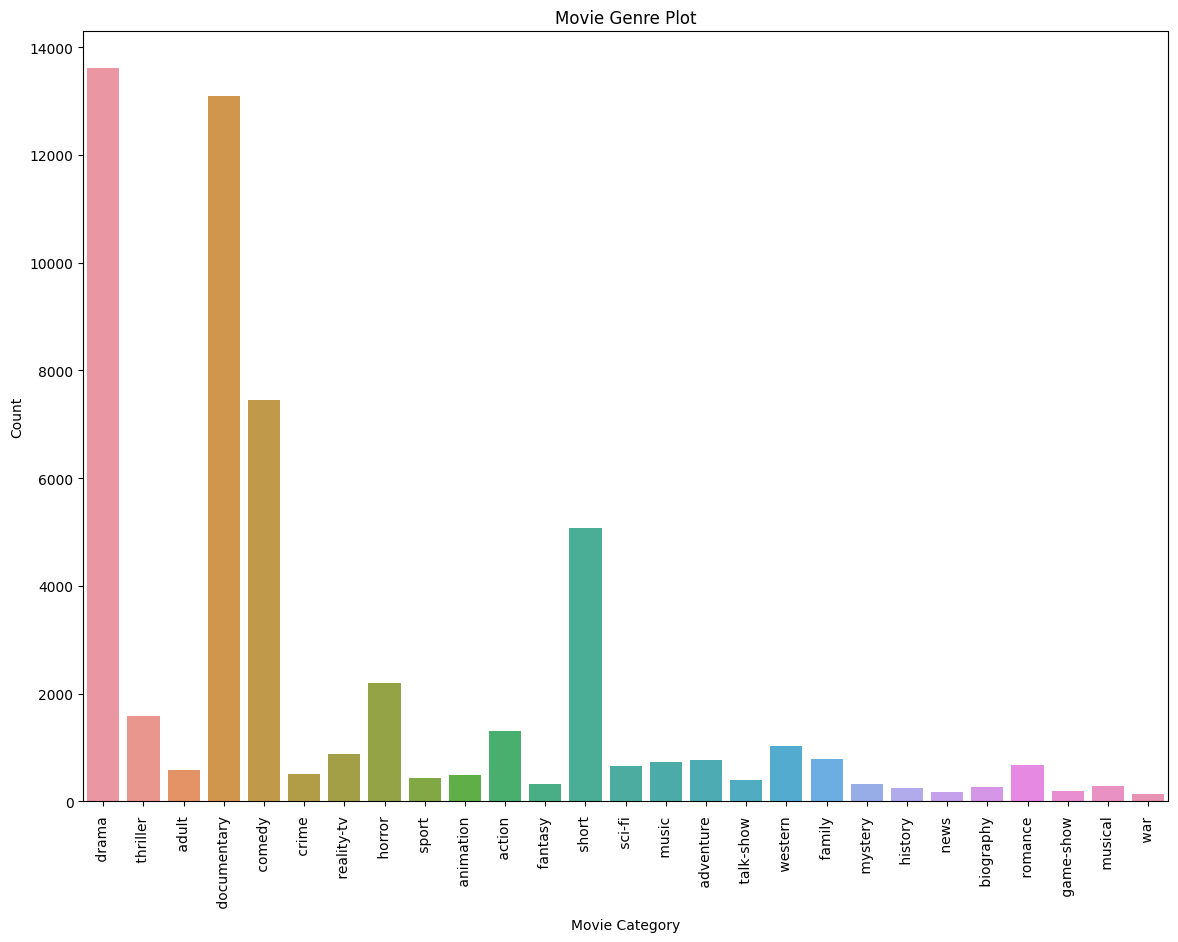

In [24]:
plt.figure(figsize=(14,10))
sns.countplot(x='genre', data=train)
plt.xlabel('Movie Category')
plt.ylabel('Count')
plt.title('Movie Genre Plot')
plt.xticks(rotation=90);
plt.show()

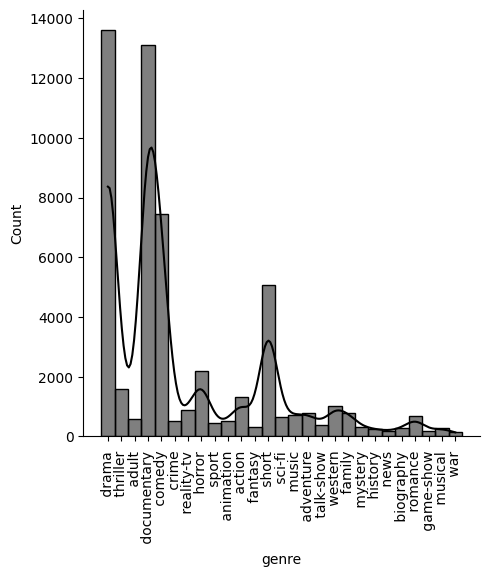

In [25]:
sns.displot(train.genre, kde =True, color = "black")
plt.xticks(rotation=90);

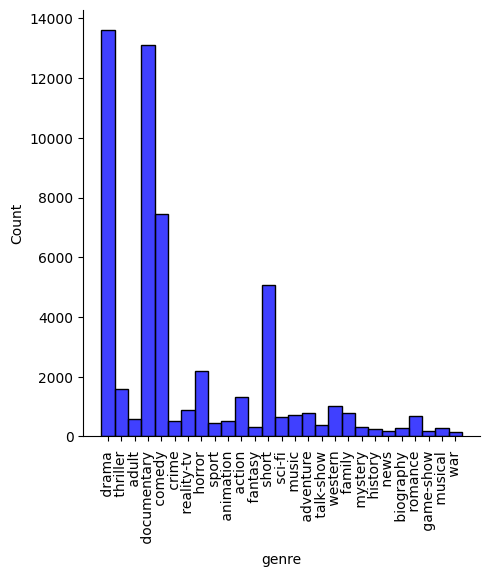

In [26]:
sns.displot(train.genre, kde=False, color = "blue")
plt.xticks(rotation=90);

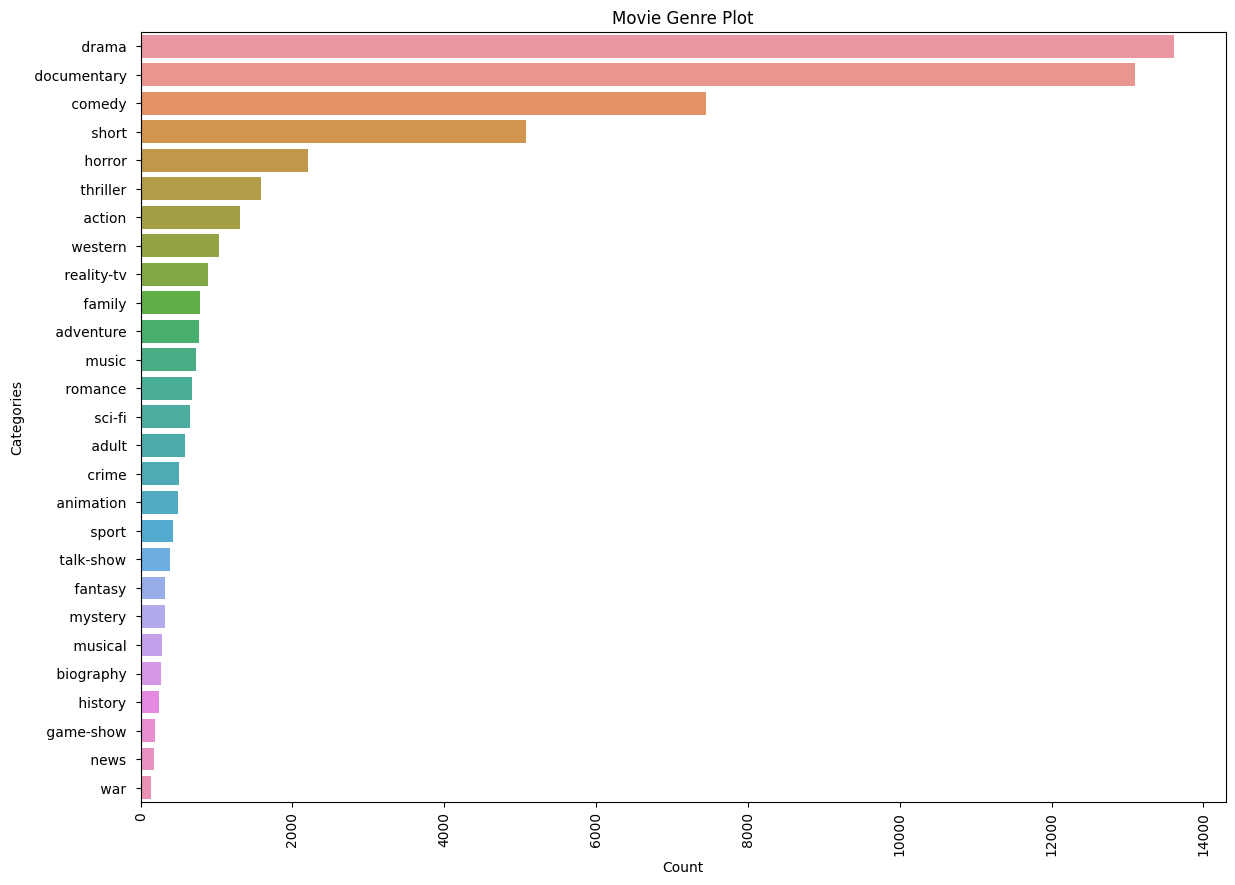

In [27]:
plt.figure(figsize = (14,10))
count1 = train.genre.value_counts()
sns.barplot(x = count1, y = count1.index, orient = 'h')
plt.xlabel('Count')
plt.ylabel('Categories')
plt.title('Movie Genre Plot')
plt.xticks(rotation=90)
plt.show()

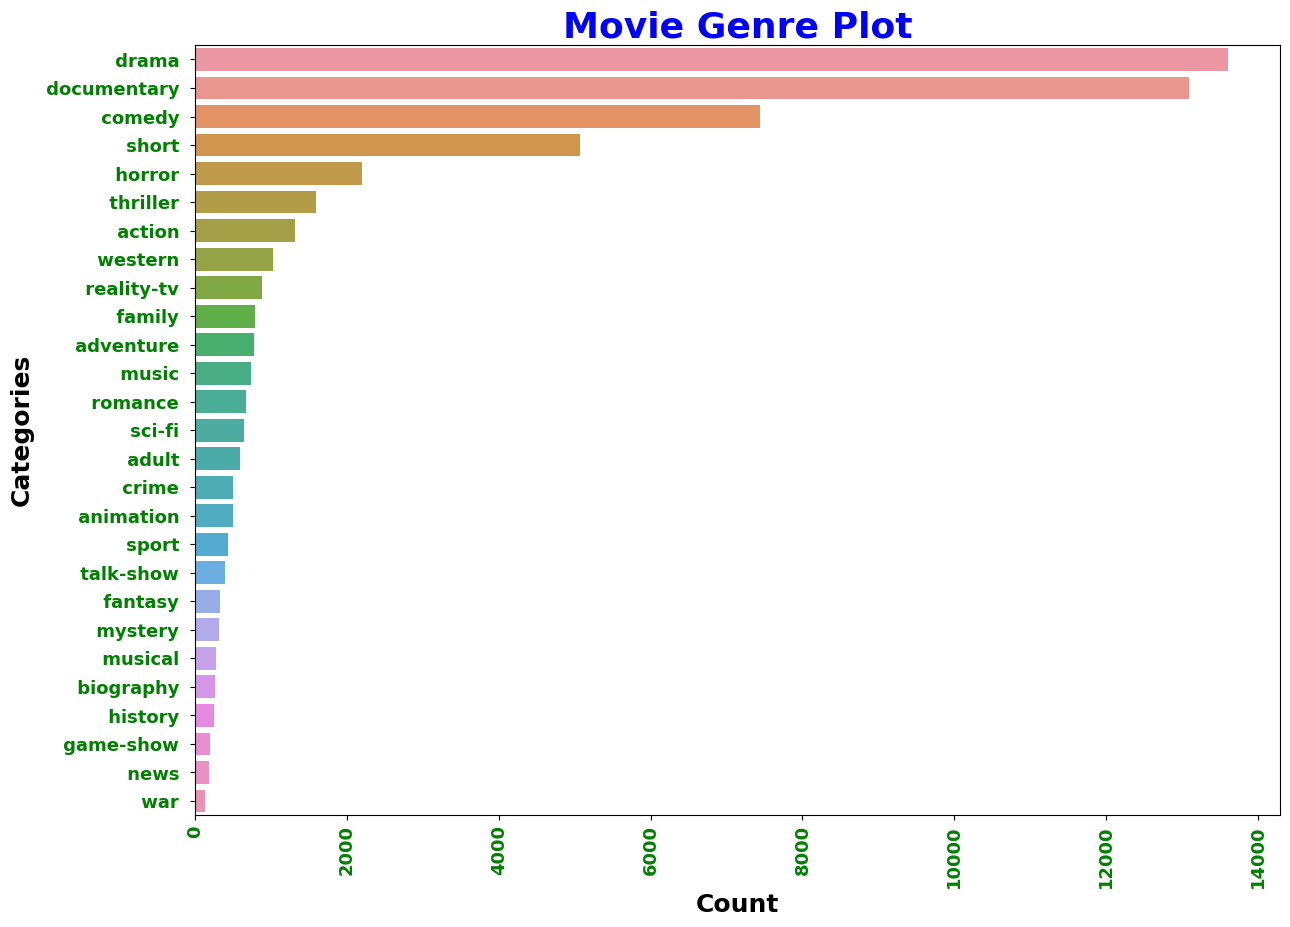

In [28]:
plt.figure(figsize = (14,10))
count1 = train.genre.value_counts()
sns.barplot(x = count1, y = count1.index, orient = 'h')
plt.xlabel('Count', fontsize = 18, fontweight = 'bold')
plt.ylabel('Categories', fontsize = 18, fontweight = 'bold')
plt.title('Movie Genre Plot', fontsize = 26, fontweight = 'bold', color = 'blue')
plt.xticks(rotation=90, fontsize = 13, fontweight = 'bold', color = 'green')
plt.yticks(fontsize = 13, fontweight = 'bold', color = 'green')
plt.show()

 **making x_train & y_train and x_test & y_test**

In [29]:
# making x_train & y_train and x_test & y_test

x_train=train.drop('genre',axis=1)
y_train=train['genre']

x_test=test.drop('genre',axis=1)
y_test=test['genre']

In [30]:
# for imputing missing values
tran_imputing_na_101 = ColumnTransformer(
    [("fill_na", SimpleImputer(missing_values=np.nan, strategy='mean'), [-1])],remainder='passthrough')

# put bins on year column
tran_binning_102 = ColumnTransformer(
    [("binning_year", KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile'), [0])],remainder='passthrough')

pipeline_101 = Pipeline([('Imputing_values',tran_imputing_na_101),('Binning',tran_binning_102)])

In [31]:
x_train=pipeline_101.fit_transform(x_train)
x_test=pipeline_101.fit_transform(x_test)

In [32]:
class merge(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,data,y=None):
        return self
    def transform(self,data,y=None):
        #data=np.array(data)
        for i in range(data.shape[0]):
            one_cell=''
            for individual in data[i]:
                one_cell += str(individual)
            data[i]=one_cell
        return data[:,:1].flatten()


# merging all the individual columns and making them one
pipeline_201 = Pipeline([('merging_columns_into_single',merge())])

In [33]:
x_train=pipeline_201.fit_transform(x_train)
x_test=pipeline_201.fit_transform(x_test)

In [34]:
class text_processing(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, data, y=None):
        return self

    def transform(self, data, y=None):
        processed = []
        for doc in nlp.pipe(data, batch_size=32, n_process=-1):  # faster & parallel
            tokens = [token.lower_ for token in doc if not token.is_punct and not token.is_stop]
            processed.append(' '.join(tokens))
        return np.array(processed)


nlp=spacy.load('en_core_web_sm') # making a spacy object
# implementing text processing
pipeline_301 = Pipeline([('merging_columns_into_single',text_processing())])

In [35]:
x_train=pipeline_301.fit_transform(x_train)
x_test=pipeline_301.transform(x_test)

In [36]:
pipeline_401 = Pipeline([('tf_idf_vector',TfidfVectorizer())])

In [37]:
x_train=pipeline_401.fit_transform(x_train)
x_test=pipeline_401.transform(x_test)

In [38]:
# converting numpy sparase metrics to Scipy metrics

x_train=sparse.csr_matrix(x_train)
x_test=sparse.csr_matrix(x_test)

In [39]:
# Performing Label Encoding on Output Column

label_encoder=LabelEncoder()

y_train=label_encoder.fit_transform(y_train)
y_test=label_encoder.fit_transform(y_test)

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,r2_score

**Implementing different Models**

In [41]:
## Implementing different Models

clf = BernoulliNB(alpha=2,fit_prior=False,binarize=0.019).fit(x_train,y_train)
y_pred=clf.predict(x_test)
print("Naive Bayes Model:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("r2_Score: ", r2_score(y_test, y_pred))

Naive Bayes Model:
[[    0     0     0     0     0     9     0   255  1050     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0    49     0    60   481     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0    16     0   188   571     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0    20     0   166   311     0     0     0
      0     1     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0     1     0   197    66     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0   774     0   983  5688     0     0     0
      0     0     0     0     0     0     0     0     0     1 

In [42]:
neigh = KNeighborsClassifier(n_neighbors=230,weights='distance').fit(x_train,y_train)
y_pred=neigh.predict(x_test)
print("K Neighbor Classifier Model:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("r2_Score: ", r2_score(y_test, y_pred))

K Neighbor Classifier Model:
[[   20     0     0     0     0    20     0   432   789     0     0     1
      0    19     0     0     0     0     0     0     2     2    14     0
      4     0    11]
 [    0    69    20     0     0    64     0   125   308     0     0     0
      0     2     0     0     0     0     0     0     0     2     0     0
      0     0     0]
 [    1    43    89     0     0    31     0   259   334     1     0     0
      0    14     0     0     0     0     0     0     1     0     1     0
      0     0     1]
 [    1     0     0     0     0    36     0   227   218     1     0     1
      0    10     0     0     0     0     0     0     4     0     0     0
      0     0     0]
 [    0     0     0     0     0     5     0   176    82     0     0     0
      0     0     0     0     0     1     0     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0  1360     0  1400  4576     3     0     7
      0    69     1     0     0     0     1     0   

In [43]:
rfc = RandomForestClassifier(n_estimators=195, random_state=42).fit(x_train,y_train)
y_pred=rfc.predict(x_test)
print("Random Forest Classifier Model:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("r2_Score: ", r2_score(y_test, y_pred))

Random Forest Classifier Model:
[[    8     0     0     0     0    52     0   294   931     0     0     0
      0    13     0     0     0     0     0     0     3     3     6     0
      3     0     1]
 [    1    45    15     0     0    90     0   100   332     0     0     0
      0     2     0     0     0     0     0     0     0     5     0     0
      0     0     0]
 [    0    17    89     0     0    49     0   195   413     0     0     0
      0     6     0     0     0     0     0     0     1     3     0     0
      0     0     2]
 [    0     0     0     2     0    72     0   157   255     0     0     0
      0     2     0     0     0     0     0     0     1     8     0     0
      1     0     0]
 [    0     0     0     0     0     5     0   174    83     0     0     0
      0     0     0     0     0     1     0     0     0     1     0     0
      0     0     0]
 [    0     0     0     1     0  1880     0   987  4526     0     0     2
      0    26     2     0     0     0     1     0

In [44]:
clf = LogisticRegression(multi_class='multinomial',solver='saga').fit(x_train,y_train)
y_pred=clf.predict(x_test)
print("Logistic Regression Model:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("r2_Score: ", r2_score(y_test, y_pred))

Logistic Regression Model:
[[  357     2     5     0     0   131     3   159   525     0     0     0
      0    39     0     0     0     0     1     0    16    34     7     0
     30     0     5]
 [    2   111    18     0     0   200     0    53   159     0     0     0
      0     5     1     0     0     0     1     1     1    37     1     0
      0     0     0]
 [   28    32   122     3     0   109     0   148   242     4     2     0
      0    27     0     0     0     0     4     0     7    32     0     0
     10     0     5]
 [   26     0     5    13     0   135     0    96   118    11     0     0
      0    17     2     0     0     0     1     0    15    59     0     0
      0     0     0]
 [    0     0     0     0     0    13     0   165    76     0     0     0
      0     1     3     0     0     0     0     0     0     6     0     0
      0     0     0]
 [   38     5     0     0     0  4335     2   468  2286     7     0     1
      0    69    10     0     0     0    10     1    1

In [45]:
svm_model = SVC(kernel='linear', random_state=42).fit(x_train, y_train)
y_pred = svm_model.predict(x_test)
print("Support Vector Machine Model:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("r2_Score: ", r2_score(y_test, y_pred))

Support Vector Machine Model:
[[  492     2    11     2     0   102     7   101   451     0     1     0
      0    34     0     0     0     0     3     0    28    28    11     0
     34     0     7]
 [    4   250    29     0     0   130     1    29   117     0     0     0
      0     4     0     0     0     0     0     0     1    23     0     0
      2     0     0]
 [   44    29   171     5     0    93     0   121   218     5    10     1
      0    19     0     0     0     0     5     0    11    22     1     0
     12     0     8]
 [   28     0    17    60     0   101     0    67   106    20    11     0
      0    14     2     0     0     0     4     0    16    51     0     0
      1     0     0]
 [    3     0     1     0     0    16     0   160    70     0     0     0
      0     1     3     0     0     0     1     0     1     5     1     1
      0     0     1]
 [   69    20    10    12     0  4480     7   382  2058    13     1     4
      0    82    17     0     1     2    22     1  